In [1]:
import os
import sys
# Get the current working directory
current_directory = os.getcwd()
# Get the parent directory of the current working directory
parent_directory = os.path.dirname(current_directory)
# Append the parent directory to the Python path
sys.path.append(parent_directory)

import time
import gc
import pickle
import cv2
import torch
import numpy as np
from PIL import Image
from collections import OrderedDict

import torch
from torchvision import datasets
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from facenet_pytorch import InceptionResnetV1

from CustomAugment import RandomFlip, RandomRotation, RandomBrightnessContrast
from CustomAugment import Normalize, RandomGaussianNoise 
import mediapipe as mp

from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score,  GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# Added imports for visualization
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
# from ConvertVideoToFrame import FrameExtractor

# face_cropper = FrameExtractor(
#     video_path=parent_directory+'/dataset/videos', 
#     output_dir=parent_directory+'/dataset/videos_cropped', 
#     nframes=200)

# result = face_cropper.process_videos()
# print(result)

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
face_detection = mp.solutions.face_detection.FaceDetection(model_selection=0, min_detection_confidence=0.6)
weights_path = wp=parent_directory+'/models/facenet-vggface2.pt'
dataset_path = parent_directory+'/dataset/videos_cropped'
face_list = []  # list of cropped faces from photos folder
name_list = []  # list of names corrospoing to cropped photos
X_train, X_test, y_train, y_test = [], [], [], []
y_pred = [] 

start_time = time.time()

In [4]:
def elapsedTime(start_time):
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"\nElapsed time: {elapsed_time:.2f} seconds")

def collate_np(batch, class_to_idx):
    images, labels = zip(*batch)
    target_size = (160, 160)
    images_np = [cv2.resize(np.array(img), target_size) for img in images]
    labels_str = [list(class_to_idx.keys())[list(class_to_idx.values()).index(label)] for label in labels]
    return images_np, labels_str

def visualize_images(images, titles, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
    axes = axes.ravel()

    for i in range(rows * cols):
        axes[i].imshow(images[i])
        axes[i].set_title(titles[i])
        axes[i].axis('off')

    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.show()

In [5]:
print(f'Running on device: {device}')

resnet = InceptionResnetV1().to(device) # can only use cpu on my machine :<

state_dict = torch.load(weights_path)
filtered_state_dict = OrderedDict((k, v) for k, v in state_dict.items() if k not in ['logits.weight', 'logits.bias'])
resnet.load_state_dict(filtered_state_dict, strict=False)

resnet.eval()

path = dataset_path

data_transforms = transforms.Compose([
    RandomBrightnessContrast(brightness_range=(0.5, 1.5), contrast_range=(0.5, 1.5)),
    RandomGaussianNoise(mean=0.0, std_range=(0.01, 0.1)),

    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    RandomRotation(angles=(-20, -1, 0, 1, 20)),
    RandomFlip(p=0.5),

    transforms.Resize((160, 160)),
    Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
if os.path.exists(path):
    dataset = datasets.ImageFolder(path, transform=data_transforms)

    idx_to_class = {i: c for c, i in dataset.class_to_idx.items()}

    workers = 0 if os.name == 'nt' else 4
    loader = DataLoader(dataset,
                        batch_size=32,
                        shuffle=True,
                        num_workers=workers,
                        collate_fn=lambda batch: collate_np(batch, dataset.class_to_idx)
                        )

    total_images = len(dataset)
    print(f"Total images: {total_images}")
else:
    print("Path doesn't exist")




Running on device: cpu
Total images: 2400


In [6]:
elapsedTime(start_time)

# display dataset after transform or during preprocessing
# Number of images to display
n_display = 24
display_count = 0
display_images = []
display_labels = []

for batch_idx, (inputs, labels) in enumerate(loader):
    # print(idx_to_class[idx[0]])
    print("Batch #: " + str(batch_idx))

    batch_size = len(inputs)  # Get the current batch size (may be smaller for the last batch)
    for j in range(batch_size):
        img = inputs[j]  # Get the j-th image in the batch
        label = labels[j]  # Get the j-th label in the batch

        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

        try:
            results = face_detection.process(img)
            # face, prob = mtcnn(img, return_prob=True)

            if results.detections:
                # Get the first detected face
                first_face = results.detections[0]

                bbox = first_face.location_data.relative_bounding_box
                x, y, w, h = int(bbox.xmin * img.shape[1]), int(bbox.ymin * img.shape[0]), \
                                int(bbox.width * img.shape[1]), int(bbox.height * img.shape[0])

                # Add padding to the image
                border = max(w, h)  # Use the maximum of width and height as the border size
                img_padded = cv2.copyMakeBorder(img, border, border, border, border, cv2.BORDER_CONSTANT,
                                                value=[0, 0, 0])

                # Crop the face region from the padded image
                face_image = img_padded[y + border:y + h + border, x + border:x + w + border]

                # Convert the cropped face from OpenCV's BGR format to RGB format
                face_image = cv2.cvtColor(face_image, cv2.COLOR_BGR2RGB)
                # Convert the NumPy array to a PyTorch tensor
                face_image = torch.from_numpy(face_image).permute(2, 0, 1).float()

                face_list.append(face_image)
                name_list.append(label)  # names are stored in a list

                print(str(j), end='')
                if display_count < n_display:
                    display_images.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                    display_labels.append(label)
                    display_count += 1
            else:
                print('.', end='')
                # print(idx_to_class[label])
                # print("No Face detected!")
                # pass
        except ValueError:
            print("Error detection!")
            continue

        # Perform garbage collection to free up memory
        del img
        gc.collect()

    elapsedTime(start_time)

# ...

print("Face detection complete...")
elapsedTime(start_time)


Elapsed time: 0.49 seconds
Batch #: 0
0.2345..891011...151617181920.2223.25...293031
Elapsed time: 7.11 seconds
Batch #: 1
0.234.678...12131415161718.20212223.25.27.2930.
Elapsed time: 13.67 seconds
Batch #: 2
..23..6789.11..14151617.192021.23.252627..3031
Elapsed time: 20.16 seconds
Batch #: 3
01.34...8...1213141516.....222324...2829.31
Elapsed time: 26.50 seconds
Batch #: 4
.1234567..1011.13.15.1718192021.232425..2829.31
Elapsed time: 32.72 seconds
Batch #: 5
01..4567.91011121314.1617..20.22232425.2728.3031
Elapsed time: 38.81 seconds
Batch #: 6
0.23..6789.1112..15.171819.2122.....28293031
Elapsed time: 45.02 seconds
Batch #: 7
012.4.67.9.111213141516.18..21222324252627282930.
Elapsed time: 51.72 seconds
Batch #: 8
.1..456789.1112131415161718.20.2223.25.27282930.
Elapsed time: 58.57 seconds
Batch #: 9
012..567.91011.13..16..19.2122232425...293031
Elapsed time: 65.19 seconds
Batch #: 10
...345.7891011.1314.16171819202122.2425262728.30.
Elapsed time: 71.94 seconds
Batch #: 11
012..567

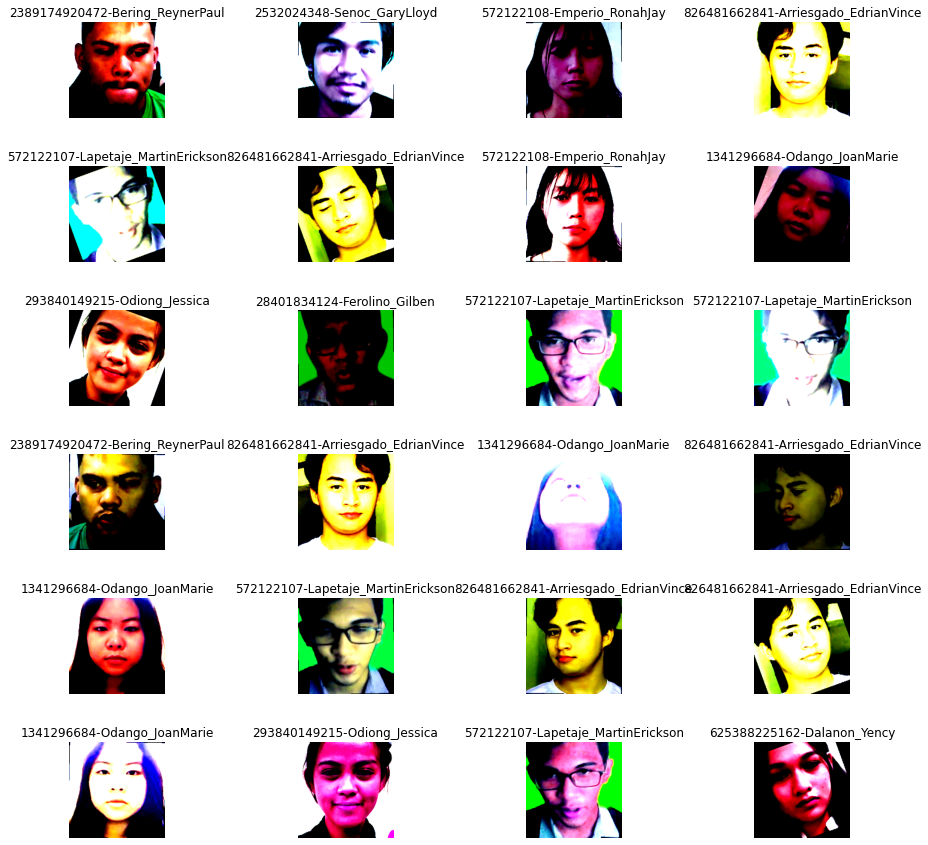

In [7]:
visualize_images(display_images, display_labels, 6, 4)
del display_images
del display_labels

In [9]:
from sklearn.utils import shuffle

num_epochs = 150
early_stopping_rounds=5
min_delta=0.001

face_list_resized = []
for face in face_list:
    face_np = face.numpy().transpose((1, 2, 0))  # Convert tensor to NumPy array and change channel order
    face_pil = Image.fromarray(face_np.astype('uint8'))  # Convert NumPy array to PIL image
    face_pil_resized = face_pil.resize((160, 160), Image.ANTIALIAS)  # Resize the PIL image
    face_resized = transforms.ToTensor()(face_pil_resized)  # Convert the resized PIL image back to a tensor
    face_list_resized.append(face_resized)

# print(face_list)
if len(face_list_resized) > 0:
    aligned = torch.stack(face_list_resized)
    
    del face_list_resized

    names = np.array(name_list)

    # Disable gradient calculation during inference
    with torch.no_grad():
        # Calculate the embeddings for the aligned faces
        embeddings = resnet(aligned).detach().cpu()

        # Encode the labels
        le = LabelEncoder()
        y = le.fit_transform(names)

        print("Training SGDClassifier...")
        elapsedTime(start_time)
        # Train an SGDClassifier with a linear model
        clf = SGDClassifier(loss='log', max_iter=1000, tol=1e-3)

        # Split the dataset into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(embeddings, y, test_size=0.2, random_state=42)

        best_accuracy = 0.0
        for epoch in range(num_epochs):
            print(f"Epoch {epoch + 1}/{num_epochs}")

            # Shuffle the training data
            X_train, y_train = shuffle(X_train, y_train, random_state=42)
            
            # Train the SGDClassifier for this epoch
            clf.partial_fit(X_train, y_train, classes=np.unique(y_train))

            # Evaluate the classifier on the test set
            y_pred = clf.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            print(f"Accuracy: {accuracy:.2f}")
            elapsedTime(start_time)

            # Check for improvement in accuracy
            if accuracy - best_accuracy > min_delta:
                best_accuracy = accuracy
                best_clf = clf
                no_improvement_counter = 0
            else:
                no_improvement_counter += 1

            # If there's no improvement for early_stopping_rounds epochs, stop training
            if no_improvement_counter >= early_stopping_rounds:
                print(f"Early stopping triggered after {early_stopping_rounds} epochs without improvement.")
                break

        # Save the trained model and the name list as a pickle file
        with open("sgd_classifier.pkl", "wb") as f:
            pickle.dump((best_clf, le, name_list), f)

        # Load the trained model and the name list from the pickle file
        with open("sgd_classifier.pkl", "rb") as f:
            loaded_clf, loaded_le, loaded_name_list = pickle.load(f)

        # Evaluate the classifier
        y_pred = loaded_clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy on the test set: {accuracy:.2f}")
        elapsedTime(start_time)
else:
    print("No faces were found in the dataset. Please check the input images.")


Training SGDClassifier...

Elapsed time: 738.45 seconds
Epoch 1/150
Accuracy: 0.86

Elapsed time: 738.54 seconds
Epoch 2/150
Accuracy: 0.84

Elapsed time: 738.57 seconds
Epoch 3/150
Accuracy: 0.84

Elapsed time: 738.61 seconds
Epoch 4/150
Accuracy: 0.85

Elapsed time: 738.64 seconds
Epoch 5/150


d:\Program Files\Python310\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
d:\Program Files\Python310\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
d:\Program Files\Python310\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
d:\Program Files\Python310\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
d:\Program Files\Python3

Accuracy: 0.86

Elapsed time: 738.68 seconds
Epoch 6/150
Accuracy: 0.89

Elapsed time: 738.71 seconds
Epoch 7/150
Accuracy: 0.88

Elapsed time: 738.74 seconds
Epoch 8/150
Accuracy: 0.88

Elapsed time: 738.78 seconds
Epoch 9/150
Accuracy: 0.89

Elapsed time: 738.82 seconds
Epoch 10/150
Accuracy: 0.88

Elapsed time: 738.85 seconds
Epoch 11/150
Accuracy: 0.88

Elapsed time: 738.88 seconds
Early stopping triggered after 5 epochs without improvement.


d:\Program Files\Python310\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
d:\Program Files\Python310\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
d:\Program Files\Python310\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
d:\Program Files\Python310\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
d:\Program Files\Python3

Accuracy on the test set: 0.88

Elapsed time: 738.90 seconds


In [ ]:
# # Get the cross-validation results as a DataFrame
# cv_results = pd.DataFrame(grid_search.cv_results_)

# # Filter out only the relevant columns
# relevant_columns = ['param_alpha', 'param_penalty', 'mean_test_score']

# cv_results = cv_results[relevant_columns]

# # Pivot the table to have a 2D grid of mean_test_score, with alpha and loss as row indices and penalty as column indices
# pivot_table = cv_results.pivot_table(values='mean_test_score', index='param_alpha', columns='param_penalty')


# # Plot the heatmap
# plt.figure(figsize=(10, 6))
# sns.heatmap(pivot_table, annot=True, cmap='viridis', fmt='.3f', linewidths=0.5)
# plt.title("Cross-Validation Mean Test Score")
# plt.xlabel("Penalty")
# plt.ylabel("(Alpha, Loss)")
# plt.show()


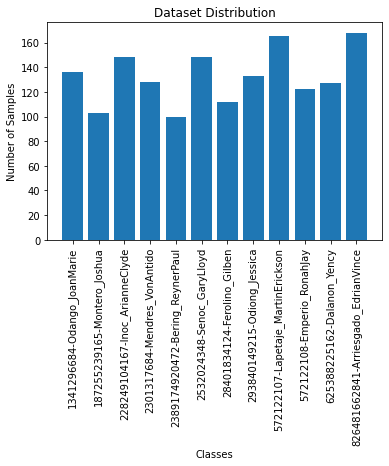

In [ ]:
# Visualize dataset distribution
unique, counts = np.unique(name_list, return_counts=True)
plt.figure()
plt.bar(unique, counts)
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.title('Dataset Distribution')
plt.xticks(rotation=90)
plt.show()

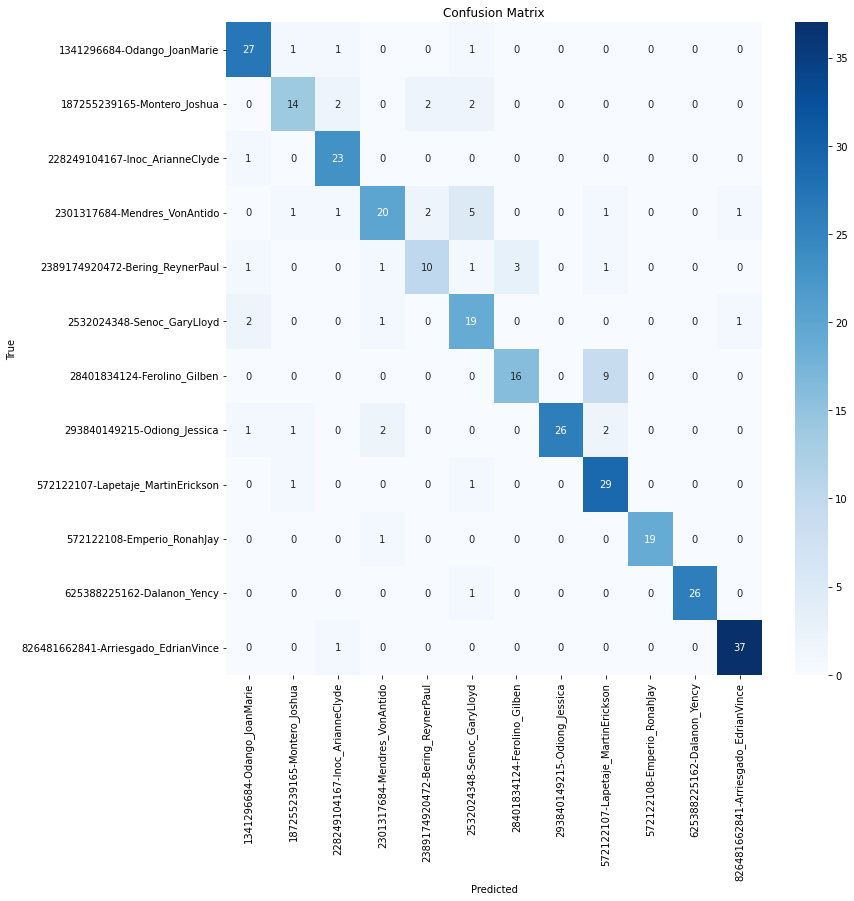

In [ ]:
# Visualize confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=loaded_le.classes_,
            yticklabels=loaded_le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Visualize classification report
print(classification_report(y_test, y_pred, target_names=loaded_le.classes_))

                                     precision    recall  f1-score   support

        1341296684-Odango_JoanMarie       0.84      0.90      0.87        30
        187255239165-Montero_Joshua       0.78      0.70      0.74        20
     228249104167-Inoc_ArianneClyde       0.82      0.96      0.88        24
       2301317684-Mendres_VonAntido       0.80      0.65      0.71        31
    2389174920472-Bering_ReynerPaul       0.71      0.59      0.65        17
         2532024348-Senoc_GaryLloyd       0.63      0.83      0.72        23
        28401834124-Ferolino_Gilben       0.84      0.64      0.73        25
        293840149215-Odiong_Jessica       1.00      0.81      0.90        32
  572122107-Lapetaje_MartinErickson       0.69      0.94      0.79        31
         572122108-Emperio_RonahJay       1.00      0.95      0.97        20
         625388225162-Dalanon_Yency       1.00      0.96      0.98        27
826481662841-Arriesgado_EdrianVince       0.95      0.97      0.96        3